In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):


    train_set_original = train_set
#     START AUGMENTING
    ARR,LABEL = [], []
    
    # select random indices
    number_of_rows = int(train_set_original.shape[1] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_original.shape[1]-1, size=int(number_of_rows), replace=False))
#     print(random_indices)
    #     iterate over every dimension
#     augment every dimension of the tensor so that at the end we have a tensor augmented
    for train_set_one in train_set_original:
    # take partial array with random indices
        train_set_one = train_set_one[random_indices,:]
    # perform jittering on the partial array
        train_set_one = train_set_one.transpose()
#         SCALE AUGMENT
        if function == 'scale':
            train_set_one = DA_Scaling(train_set_one)
        elif function == 'jitter':
            train_set_one = DA_Jitter(train_set_one)
        elif function == 'magWarp':
            train_set_one = DA_MagWarp(train_set_one)
        elif function == 'timeWarp':
            train_set_one = DA_TimeWarp(train_set_one)
        elif function == 'rotation':
            train_set_one = DA_Rotation(train_set_one)
        elif function == 'permutation':
            train_set_one = DA_Permutation(train_set_one)
        else:
            print("Error no augmentation function")
            break
            
        train_set_one = train_set_one.transpose()
        
#     create an array ARR only of augmented data
        ARR = [*ARR, train_set_one]
    
    ARR = np.array(ARR)
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     print(LABEL)
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, ARR), axis = 1)
#     print(train_set[0,0,0])
#     print(ARR[0,0,0])
#     print(train_set[1,0,0])
#     print(ARR[1,0,0])
#     print(train_set[2,0,0])
#     print(ARR[2,0,0])
#     print(train_set[3,0,0])
#     print(ARR[3,0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented


In [4]:
# def model_network():
#     seed_value = 34567892
#     os.environ['PYTHONHASHSEED']=str(seed_value)
#     tf.random.set_seed(seed_value)
        

#     model = Sequential()
#     model.add(Input(shape=(2400,)))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     opt = SGD(learning_rate=0.0001,momentum=0.4)
# #     opt = Adam(learning_rate=0.00001)
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',Recall(), Precision()])
#     return model

In [5]:
def model_network():
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)
        

    model = Sequential()
    model.add(Input(shape=(2400,)))
#     model.add(Dense(200, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.001,momentum=0.5)
#     opt = Adam(learning_rate=0.003)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',Recall(), Precision()])
    return model

2022-06-01 15:10:12.591940: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


evaluate original:  [0.5562146306037903, 0.7251625061035156, 0.8590475916862488, 0.6701337099075317]


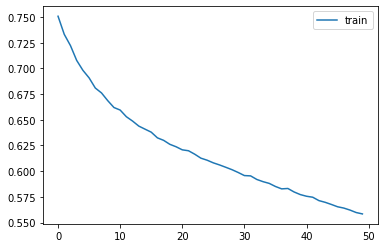

jitter
evaluate augmented :  jitter [0.5135899186134338, 0.7725162506103516, 0.9257143139839172, 0.7023121118545532]


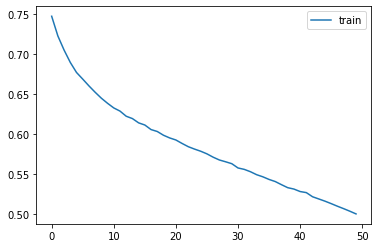

evaluate augmented :  jitter [0.5129339098930359, 0.7660167217254639, 0.9219047427177429, 0.696402907371521]


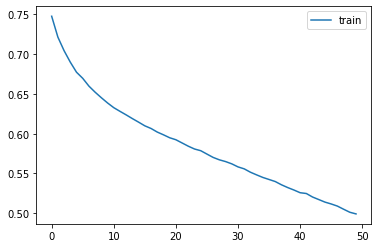

[77.25162506103516, 76.60167217254639]
76.93% (+/- 0.32%)
scale
evaluate augmented :  scale [0.5264012217521667, 0.7567316889762878, 0.9009523987770081, 0.6925329566001892]


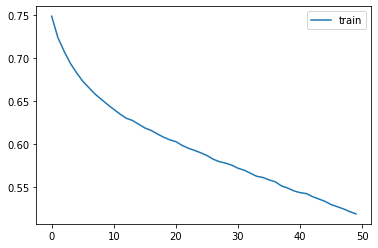

evaluate augmented :  scale [0.5257161855697632, 0.7632312178611755, 0.9066666960716248, 0.6979472041130066]


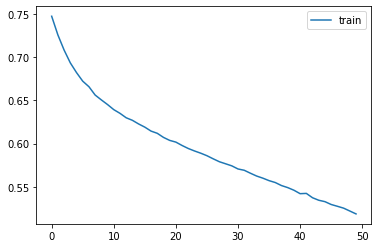

[75.67316889762878, 76.32312178611755]
76.00% (+/- 0.32%)
magWarp
evaluate augmented :  magWarp [0.5151239633560181, 0.7623026967048645, 0.9142857193946838, 0.6946454644203186]


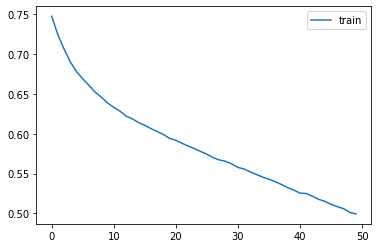

evaluate augmented :  magWarp [0.5124671459197998, 0.7585886716842651, 0.9066666960716248, 0.6928675174713135]


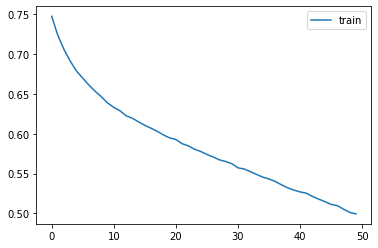

[76.23026967048645, 75.85886716842651]
76.04% (+/- 0.19%)
timeWarp
evaluate augmented :  timeWarp [0.5463815331459045, 0.736304521560669, 0.883809506893158, 0.6754003167152405]


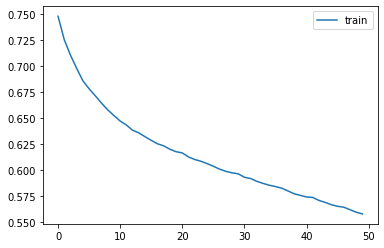

evaluate augmented :  timeWarp [0.5458835363388062, 0.7418755888938904, 0.8914285898208618, 0.6792452931404114]


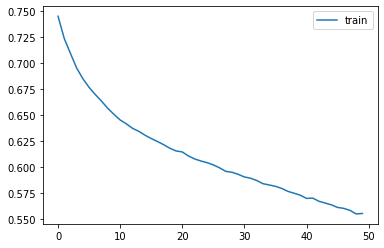

[73.6304521560669, 74.18755888938904]
73.91% (+/- 0.28%)
permutation
evaluate augmented :  permutation [0.5526919960975647, 0.727948009967804, 0.9028571248054504, 0.6620111465454102]


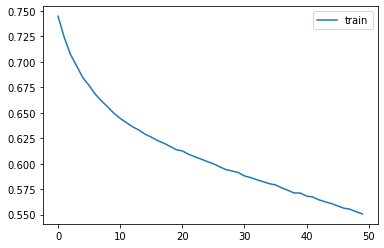

evaluate augmented :  permutation [0.5280874967575073, 0.7465181350708008, 0.9028571248054504, 0.681034505367279]


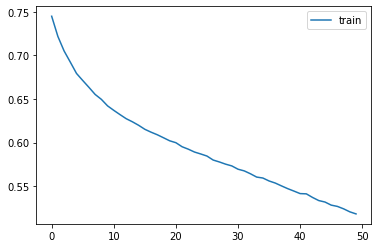

[72.7948009967804, 74.65181350708008]
73.72% (+/- 0.93%)


In [6]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']
# techniques = ['jitter','scale']

arr_bvp, arr_bvc,arr_acc,arr_tem = [],[],[],[]
std_arr = []
arr_bvp_percentage = []
tec_bvp = 0

recall_bvp = []
precision_bvp = []

train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)




# for dim in range(0, 4):
train_set_arr = train_set[1]
test_set_arr = test_set[1]

model = model_network()

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=50, batch_size= 128, shuffle=True, verbose=0, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
tec_bvp = scores1[1]
recall_original = scores1[2]
precision_original = scores1[3]

recall_bvp.append(recall_original)
precision_bvp.append(precision_original)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    avg_tec_bvp = []
    
    recall_original, precision_original, recall_aug, precision_aug = 0,0,0,0
    cvscores = []
    
    tec_len = 2
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        train_set_augmented, label_set_augmented = augment_data(train_set, train_label, technique)
        
        train_set_arr_augment = train_set_augmented[1]
        test_set_arr = test_set[1]
        model = model_network()

        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=50, batch_size= 128, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)
        #     --------------------------------------------------------------------
        print("evaluate augmented : ", technique, scores2)

        avg_tec_bvp.append(scores2[1])
        std_arr.append(scores2[1])
        cvscores.append(scores2[1] * 100)
        recall_aug += scores2[2]
        precision_aug += scores2[3]

        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    arr_bvp.append(np.mean(avg_tec_bvp))
    recall_bvp.append(recall_aug/tec_len)
    precision_bvp.append(precision_aug/tec_len)
    print(cvscores)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#     std_arr.append(np.std(cvscores))

    arr_bvp_percentage.append(round((np.mean(avg_tec_bvp) - tec_bvp) * 100, 4))


# insert bvp and baseline
arr_bvp.insert(0, tec_bvp)
std_arr = [np.std(std_arr)]
std_arr.insert(0, 0)
# recall_bvp.insert(0, recall_original)
# precision_bvp.insert(0, precision_original)

arr_bvp.insert(0, 'bvp')
recall_bvp.insert(0, 'RECALL')
precision_bvp.insert(0, 'PRECISION')
std_arr.insert(0, 'STD')

# print("STD: ", std)
header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(arr_bvp)
    writer.writerow(recall_bvp)
    writer.writerow(precision_bvp)
    writer.writerow(std_arr)
    writer.writerow([])
    arr_bvp_percentage.insert(0, 0)
    arr_bvp_percentage.insert(0, 'bvp')
    writer.writerow(arr_bvp_percentage)

